In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(6)*train_x + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)

train_y = torch.stack([one,two], int(-1))
#train_y = torch.stack([one, two], int(-1))


In [3]:
print(train_x)
print(train_y)
print(np.shape(train_y))

# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([-2.0000, -1.9184, -1.8367, -1.7551, -1.6735, -1.5918, -1.5102, -1.4286,
        -1.3469, -1.2653, -1.1837, -1.1020, -1.0204, -0.9388, -0.8571, -0.7755,
        -0.6939, -0.6122, -0.5306, -0.4490, -0.3673, -0.2857, -0.2041, -0.1224,
        -0.0408,  0.0408,  0.1224,  0.2041,  0.2857,  0.3673,  0.4490,  0.5306,
         0.6122,  0.6939,  0.7755,  0.8571,  0.9388,  1.0204,  1.1020,  1.1837,
         1.2653,  1.3469,  1.4286,  1.5102,  1.5918,  1.6735,  1.7551,  1.8367,
         1.9184,  2.0000])
tensor([[ -7.8938, -11.8380],
        [ -7.1008, -11.8162],
        [ -6.2219, -11.0000],
        [ -5.4973, -10.6438],
        [ -4.3770, -10.0265],
        [ -4.1498,  -9.8745],
        [ -3.6243,  -9.2358],
        [ -2.8110,  -8.5081],
        [ -2.1319,  -8.1164],
        [ -2.0848,  -7.5771],
        [ -1.3473,  -7.2970],
        [ -1.5606,  -6.6472],
        [ -0.8700,  -6.2801],
        [ -0.9162,  -5.8033],
        [ -0.8829,  -5.4771],
        [ -0.5522,  -4.8208],
        [ -0.

In [4]:

len(train_y.shape)

2

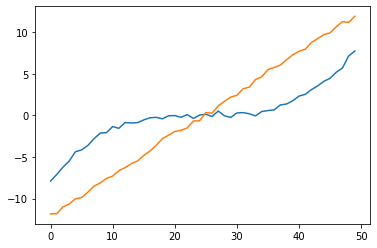

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1^2, 1))
        R = matrix(2, 2, (1, dx2^2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[ 1.0000e+00,  1.0000e+00,  9.9667e-01,  ..., -6.6522e-03,
          3.3546e-04, -5.0319e-03],
        [ 1.0000e+00,  3.0000e+00,  9.9003e-01,  ...,  6.7948e-02,
         -5.0319e-03,  5.4680e-02],
        [ 9.9667e-01,  9.9003e-01,  1.0000e+00,  ..., -8.7267e-03,
          4.6345e-04, -6.6522e-03],
        ...,
        [-6.6522e-03,  6.7948e-02, -8.7267e-03,  ...,  3.0000e+00,
          9.9003e-01,  2.9502e+00],
        [ 3.3546e-04, -5.0319e-03,  4.6345e-04,  ...,  9.9003e-01,
          1.0000e+00,  1.0000e+00],
        [-5.0319e-03,  5.4680e-02, -6.6522e-03,  ...,  2.9502e+00,
          1.0000e+00,  3.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.6527e+01,  0.0000e+00],
        [ 5.1993e+01,  0.0000e+00],
        [ 3.0933e+01,  0.0000e+00],
        [ 2.8484e+01,  0.0000e+00],
        [ 1.7336e+01,  0.0000e+00],
        [ 6.7975e+00,  0.0000e+00],
        [ 4.3840e+00,  0.0000e+00],
        [ 2.5067e+00,  0.0000e+00],
        [ 8.3485e-01,

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py:643: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  print(result.eig())


tensor([[ 1.1052e+00,  1.3499e+00,  1.1007e+00,  ..., -2.0296e-03,
          6.3073e-05, -1.4285e-03],
        [ 1.3499e+00,  4.9462e+00,  1.3334e+00,  ...,  3.3814e-02,
         -1.4285e-03,  2.5184e-02],
        [ 1.1007e+00,  1.3334e+00,  1.1052e+00,  ..., -2.8574e-03,
          9.3601e-05, -2.0296e-03],
        ...,
        [-2.0296e-03,  3.3814e-02, -2.8574e-03,  ...,  4.9462e+00,
          1.3334e+00,  4.8460e+00],
        [ 6.3073e-05, -1.4285e-03,  9.3601e-05,  ...,  1.3334e+00,
          1.1052e+00,  1.3499e+00],
        [-1.4285e-03,  2.5184e-02, -2.0296e-03,  ...,  4.8460e+00,
          1.3499e+00,  4.9462e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.3627e+01,  0.0000e+00],
        [ 7.9234e+01,  0.0000e+00],
        [ 4.5257e+01,  0.0000e+00],
        [ 3.8350e+01,  0.0000e+00],
        [ 2.7255e+01,  0.0000e+00],
        [ 1.4183e+01,  0.0000e+00],
        [ 7.0968e+00,  0.0000e+00],
        [ 4.2391e+00,  0.0000e+00],
        [ 2.4565e+00,

tensor([[ 1.3415e+00,  2.3987e+00,  1.3335e+00,  ..., -6.9341e-05,
          8.2249e-07, -4.0605e-05],
        [ 2.3987e+00,  1.2867e+01,  2.3561e+00,  ...,  2.7746e-03,
         -4.0605e-05,  1.7089e-03],
        [ 1.3335e+00,  2.3561e+00,  1.3415e+00,  ..., -1.1690e-04,
          1.4659e-06, -6.9341e-05],
        ...,
        [-6.9341e-05,  2.7746e-03, -1.1690e-04,  ...,  1.2867e+01,
          2.3561e+00,  1.2487e+01],
        [ 8.2249e-07, -4.0605e-05,  1.4659e-06,  ...,  2.3561e+00,
          1.3415e+00,  2.3987e+00],
        [-4.0605e-05,  1.7089e-03, -6.9341e-05,  ...,  1.2487e+01,
          2.3987e+00,  1.2867e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.8452e+02,  0.0000e+00],
        [ 1.7570e+02,  0.0000e+00],
        [ 1.1377e+02,  0.0000e+00],
        [ 9.2633e+01,  0.0000e+00],
        [ 5.2834e+01,  0.0000e+00],
        [ 3.5790e+01,  0.0000e+00],
        [ 2.7432e+01,  0.0000e+00],
        [ 1.1986e+01,  0.0000e+00],
        [ 7.8103e+00,

tensor([[ 1.6048e+00,  3.9678e+00,  1.5916e+00,  ..., -8.3759e-07,
          4.1219e-09, -3.9298e-07],
        [ 3.9678e+00,  2.9431e+01,  3.8704e+00,  ...,  6.8149e-05,
         -3.9298e-07,  3.3529e-05],
        [ 1.5916e+00,  3.8704e+00,  1.6048e+00,  ..., -1.7544e-06,
          9.1652e-09, -8.3759e-07],
        ...,
        [-8.3759e-07,  6.8149e-05, -1.7544e-06,  ...,  2.9431e+01,
          3.8704e+00,  2.8230e+01],
        [ 4.1219e-09, -3.9298e-07,  9.1652e-09,  ...,  3.8704e+00,
          1.6048e+00,  3.9678e+00],
        [-3.9298e-07,  3.3529e-05, -8.3759e-07,  ...,  2.8230e+01,
          3.9678e+00,  2.9431e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.6210e+02,  0.0000e+00],
        [ 3.6141e+02,  0.0000e+00],
        [ 2.3760e+02,  0.0000e+00],
        [ 2.2700e+02,  0.0000e+00],
        [ 1.2338e+02,  0.0000e+00],
        [ 9.8940e+01,  0.0000e+00],
        [ 5.3355e+01,  0.0000e+00],
        [ 3.5004e+01,  0.0000e+00],
        [ 2.5116e+01,

tensor([[ 1.8845e+00,  5.9212e+00,  1.8649e+00,  ..., -9.3578e-09,
          2.2835e-11, -3.5353e-09],
        [ 5.9212e+00,  5.5814e+01,  5.7369e+00,  ...,  1.2702e-06,
         -3.5353e-09,  5.0244e-07],
        [ 1.8649e+00,  5.7369e+00,  1.8845e+00,  ..., -2.4234e-08,
          6.3043e-11, -9.3578e-09],
        ...,
        [-9.3578e-09,  1.2702e-06, -2.4234e-08,  ...,  5.5814e+01,
          5.7369e+00,  5.2928e+01],
        [ 2.2835e-11, -3.5353e-09,  6.3043e-11,  ...,  5.7369e+00,
          1.8845e+00,  5.9212e+00],
        [-3.5353e-09,  5.0244e-07, -9.3578e-09,  ...,  5.2928e+01,
          5.9212e+00,  5.5814e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.2941e+02,  0.0000e+00],
        [ 6.1234e+02,  0.0000e+00],
        [ 4.5131e+02,  0.0000e+00],
        [ 4.0756e+02,  0.0000e+00],
        [ 2.5252e+02,  0.0000e+00],
        [ 2.1454e+02,  0.0000e+00],
        [ 1.0239e+02,  0.0000e+00],
        [ 9.6263e+01,  0.0000e+00],
        [ 3.9320e+01,

tensor([[ 2.1712e+00,  7.9170e+00,  2.1450e+00,  ..., -3.0332e-10,
          4.6558e-13, -9.7346e-11],
        [ 7.9170e+00,  8.6604e+01,  7.6313e+00,  ...,  5.6350e-08,
         -9.7346e-11,  1.8922e-08],
        [ 2.1450e+00,  7.6313e+00,  2.1712e+00,  ..., -9.2159e-10,
          1.5129e-12, -3.0332e-10],
        ...,
        [-3.0332e-10,  5.6350e-08, -9.2159e-10,  ...,  8.6604e+01,
          7.6313e+00,  8.1417e+01],
        [ 4.6558e-13, -9.7346e-11,  1.5129e-12,  ...,  7.6313e+00,
          2.1712e+00,  7.9170e+00],
        [-9.7346e-11,  1.8922e-08, -3.0332e-10,  ...,  8.1417e+01,
          7.9170e+00,  8.6604e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 9.0918e+02,  0.0000e+00],
        [ 9.0289e+02,  0.0000e+00],
        [ 6.5518e+02,  0.0000e+00],
        [ 6.5178e+02,  0.0000e+00],
        [ 3.9019e+02,  0.0000e+00],
        [ 3.6270e+02,  0.0000e+00],
        [ 1.9883e+02,  0.0000e+00],
        [ 1.4673e+02,  0.0000e+00],
        [ 8.6118e+01,

tensor([[ 2.4568e+00,  9.5769e+00,  2.4251e+00,  ..., -5.6834e-11,
          7.0282e-14, -1.6813e-11],
        [ 9.5769e+00,  1.1200e+02,  9.2077e+00,  ...,  1.2144e-08,
         -1.6813e-11,  3.7580e-09],
        [ 2.4251e+00,  9.2077e+00,  2.4568e+00,  ..., -1.8701e-10,
          2.4774e-13, -5.6834e-11],
        ...,
        [-5.6834e-11,  1.2144e-08, -1.8701e-10,  ...,  1.1200e+02,
          9.2077e+00,  1.0483e+02],
        [ 7.0282e-14, -1.6813e-11,  2.4774e-13,  ...,  9.2077e+00,
          2.4568e+00,  9.5769e+00],
        [-1.6813e-11,  3.7580e-09, -5.6834e-11,  ...,  1.0483e+02,
          9.5769e+00,  1.1200e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1417e+03,  0.0000e+00],
        [ 1.1363e+03,  0.0000e+00],
        [ 8.5088e+02,  0.0000e+00],
        [ 8.1871e+02,  0.0000e+00],
        [ 5.3105e+02,  0.0000e+00],
        [ 4.5718e+02,  0.0000e+00],
        [ 2.7917e+02,  0.0000e+00],
        [ 1.9770e+02,  0.0000e+00],
        [ 1.1692e+02,

tensor([[ 2.7344e+00,  1.0623e+01,  2.6992e+00,  ..., -6.9431e-11,
          8.6805e-14, -2.0627e-11],
        [ 1.0623e+01,  1.2382e+02,  1.0215e+01,  ...,  1.4733e-08,
         -2.0627e-11,  4.5782e-09],
        [ 2.6992e+00,  1.0215e+01,  2.7344e+00,  ..., -2.2753e-10,
          3.0470e-13, -6.9431e-11],
        ...,
        [-6.9431e-11,  1.4733e-08, -2.2753e-10,  ...,  1.2382e+02,
          1.0215e+01,  1.1593e+02],
        [ 8.6805e-14, -2.0627e-11,  3.0470e-13,  ...,  1.0215e+01,
          2.7344e+00,  1.0623e+01],
        [-2.0627e-11,  4.5782e-09, -6.9431e-11,  ...,  1.1593e+02,
          1.0623e+01,  1.2382e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2637e+03,  0.0000e+00],
        [ 1.2584e+03,  0.0000e+00],
        [ 9.4043e+02,  0.0000e+00],
        [ 9.0661e+02,  0.0000e+00],
        [ 5.8588e+02,  0.0000e+00],
        [ 5.0582e+02,  0.0000e+00],
        [ 3.0768e+02,  0.0000e+00],
        [ 2.1778e+02,  0.0000e+00],
        [ 1.2920e+02,

tensor([[ 2.9993e+00,  1.0981e+01,  2.9630e+00,  ..., -3.7702e-10,
          5.7123e-13, -1.2042e-10],
        [ 1.0981e+01,  1.2061e+02,  1.0583e+01,  ...,  7.0640e-08,
         -1.2042e-10,  2.3606e-08],
        [ 2.9630e+00,  1.0583e+01,  2.9993e+00,  ..., -1.1509e-09,
          1.8651e-12, -3.7702e-10],
        ...,
        [-3.7702e-10,  7.0640e-08, -1.1509e-09,  ...,  1.2061e+02,
          1.0583e+01,  1.1336e+02],
        [ 5.7123e-13, -1.2042e-10,  1.8651e-12,  ...,  1.0583e+01,
          2.9993e+00,  1.0981e+01],
        [-1.2042e-10,  2.3606e-08, -3.7702e-10,  ...,  1.1336e+02,
          1.0981e+01,  1.2061e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2636e+03,  0.0000e+00],
        [ 1.2558e+03,  0.0000e+00],
        [ 9.1051e+02,  0.0000e+00],
        [ 9.0840e+02,  0.0000e+00],
        [ 5.4537e+02,  0.0000e+00],
        [ 5.0409e+02,  0.0000e+00],
        [ 2.7859e+02,  0.0000e+00],
        [ 2.0446e+02,  0.0000e+00],
        [ 1.2058e+02,

tensor([[ 3.2497e+00,  1.0753e+01,  3.2141e+00,  ..., -4.9815e-09,
          1.0376e-11, -1.7832e-09],
        [ 1.0753e+01,  1.0673e+02,  1.0400e+01,  ...,  7.5427e-07,
         -1.7832e-09,  2.8263e-07],
        [ 3.2141e+00,  1.0400e+01,  3.2497e+00,  ..., -1.3600e-08,
          3.0231e-11, -4.9815e-09],
        ...,
        [-4.9815e-09,  7.5427e-07, -1.3600e-08,  ...,  1.0673e+02,
          1.0400e+01,  1.0092e+02],
        [ 1.0376e-11, -1.7832e-09,  3.0231e-11,  ...,  1.0400e+01,
          3.2497e+00,  1.0753e+01],
        [-1.7832e-09,  2.8263e-07, -4.9815e-09,  ...,  1.0092e+02,
          1.0753e+01,  1.0673e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1755e+03,  0.0000e+00],
        [ 1.1492e+03,  0.0000e+00],
        [ 8.4671e+02,  0.0000e+00],
        [ 7.8665e+02,  0.0000e+00],
        [ 4.7176e+02,  0.0000e+00],
        [ 4.3525e+02,  0.0000e+00],
        [ 2.0566e+02,  0.0000e+00],
        [ 1.8815e+02,  0.0000e+00],
        [ 8.6790e+01,

tensor([[ 3.4863e+00,  1.0122e+01,  3.4527e+00,  ..., -9.2230e-08,
          2.8524e-10, -3.7641e-08],
        [ 1.0122e+01,  8.8160e+01,  9.8304e+00,  ...,  1.0585e-05,
         -3.7641e-08,  4.5254e-06],
        [ 3.4527e+00,  9.8304e+00,  3.4863e+00,  ..., -2.2145e-07,
          7.2900e-10, -9.2230e-08],
        ...,
        [-9.2230e-08,  1.0585e-05, -2.2145e-07,  ...,  8.8160e+01,
          9.8304e+00,  8.3944e+01],
        [ 2.8524e-10, -3.7641e-08,  7.2900e-10,  ...,  9.8304e+00,
          3.4863e+00,  1.0122e+01],
        [-3.7641e-08,  4.5254e-06, -9.2230e-08,  ...,  8.3944e+01,
          1.0122e+01,  8.8160e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0274e+03,  0.0000e+00],
        [ 9.9931e+02,  0.0000e+00],
        [ 7.2461e+02,  0.0000e+00],
        [ 6.4226e+02,  0.0000e+00],
        [ 4.0408e+02,  0.0000e+00],
        [ 3.1126e+02,  0.0000e+00],
        [ 1.7034e+02,  0.0000e+00],
        [ 1.2672e+02,  0.0000e+00],
        [ 6.6706e+01,

tensor([[ 3.7128e+00,  9.2933e+00,  3.6820e+00,  ..., -1.5714e-06,
          7.4687e-09, -7.3000e-07],
        [ 9.2933e+00,  6.9784e+01,  9.0624e+00,  ...,  1.3128e-04,
         -7.3000e-07,  6.3948e-05],
        [ 3.6820e+00,  9.0624e+00,  3.7128e+00,  ..., -3.3234e-06,
          1.6772e-08, -1.5714e-06],
        ...,
        [-1.5714e-06,  1.3128e-04, -3.3234e-06,  ...,  6.9784e+01,
          9.0624e+00,  6.6903e+01],
        [ 7.4687e-09, -7.3000e-07,  1.6772e-08,  ...,  9.0624e+00,
          3.7128e+00,  9.2933e+00],
        [-7.3000e-07,  6.3948e-05, -1.5714e-06,  ...,  6.6903e+01,
          9.2933e+00,  6.9784e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.5545e+02,  0.0000e+00],
        [ 8.5141e+02,  0.0000e+00],
        [ 5.6536e+02,  0.0000e+00],
        [ 5.3473e+02,  0.0000e+00],
        [ 2.9607e+02,  0.0000e+00],
        [ 2.3359e+02,  0.0000e+00],
        [ 1.2850e+02,  0.0000e+00],
        [ 8.1872e+01,  0.0000e+00],
        [ 6.0681e+01,

tensor([[ 3.9361e+00,  8.4437e+00,  3.9081e+00,  ..., -1.9002e-05,
          1.3866e-07, -9.9119e-06],
        [ 8.4437e+00,  5.4339e+01,  8.2637e+00,  ...,  1.1362e-03,
         -9.9119e-06,  6.2221e-04],
        [ 3.9081e+00,  8.2637e+00,  3.9361e+00,  ..., -3.5878e-05,
          2.7737e-07, -1.9002e-05],
        ...,
        [-1.9002e-05,  1.1362e-03, -3.5878e-05,  ...,  5.4339e+01,
          8.2637e+00,  5.2414e+01],
        [ 1.3866e-07, -9.9119e-06,  2.7737e-07,  ...,  8.2637e+00,
          3.9361e+00,  8.4437e+00],
        [-9.9119e-06,  6.2221e-04, -1.9002e-05,  ...,  5.2414e+01,
          8.4437e+00,  5.4339e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.1838e+02,  0.0000e+00],
        [ 6.9584e+02,  0.0000e+00],
        [ 4.5360e+02,  0.0000e+00],
        [ 4.1455e+02,  0.0000e+00],
        [ 2.0157e+02,  0.0000e+00],
        [ 1.9040e+02,  0.0000e+00],
        [ 8.4614e+01,  0.0000e+00],
        [ 7.5643e+01,  0.0000e+00],
        [ 3.5487e+01,

tensor([[ 4.1660e+00,  7.7079e+00,  4.1404e+00,  ..., -1.4330e-04,
          1.5541e-06, -8.2244e-05],
        [ 7.7079e+00,  4.2783e+01,  7.5661e+00,  ...,  6.1868e-03,
         -8.2244e-05,  3.7332e-03],
        [ 4.1404e+00,  7.5661e+00,  4.1660e+00,  ..., -2.4639e-04,
          2.8260e-06, -1.4330e-04],
        ...,
        [-1.4330e-04,  6.1868e-03, -2.4639e-04,  ...,  4.2783e+01,
          7.5661e+00,  4.1474e+01],
        [ 1.5541e-06, -8.2244e-05,  2.8260e-06,  ...,  7.5661e+00,
          4.1660e+00,  7.7079e+00],
        [-8.2244e-05,  3.7332e-03, -1.4330e-04,  ...,  4.1474e+01,
          7.7079e+00,  4.2783e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.0521e+02,  0.0000e+00],
        [ 5.7582e+02,  0.0000e+00],
        [ 3.7666e+02,  0.0000e+00],
        [ 3.0910e+02,  0.0000e+00],
        [ 1.7437e+02,  0.0000e+00],
        [ 1.2145e+02,  0.0000e+00],
        [ 8.8319e+01,  0.0000e+00],
        [ 4.2665e+01,  0.0000e+00],
        [ 2.5814e+01,

tensor([[ 4.4131e+00,  7.1490e+00,  4.3894e+00,  ..., -6.7803e-04,
          1.0387e-05, -4.1929e-04],
        [ 7.1490e+00,  3.4743e+01,  7.0338e+00,  ...,  2.1735e-02,
         -4.1929e-04,  1.4154e-02],
        [ 4.3894e+00,  7.0338e+00,  4.4131e+00,  ..., -1.0836e-03,
          1.7533e-05, -6.7803e-04],
        ...,
        [-6.7803e-04,  2.1735e-02, -1.0836e-03,  ...,  3.4743e+01,
          7.0338e+00,  3.3811e+01],
        [ 1.0387e-05, -4.1929e-04,  1.7533e-05,  ...,  7.0338e+00,
          4.4131e+00,  7.1490e+00],
        [-4.1929e-04,  1.4154e-02, -6.7803e-04,  ...,  3.3811e+01,
          7.1490e+00,  3.4743e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.1598e+02,  0.0000e+00],
        [ 4.9801e+02,  0.0000e+00],
        [ 3.0512e+02,  0.0000e+00],
        [ 2.5567e+02,  0.0000e+00],
        [ 1.3920e+02,  0.0000e+00],
        [ 1.0809e+02,  0.0000e+00],
        [ 6.8375e+01,  0.0000e+00],
        [ 2.8305e+01,  0.0000e+00],
        [ 2.1630e+01,

tensor([[ 4.6885e+00,  6.7982e+00,  4.6659e+00,  ..., -2.1173e-03,
          4.2982e-05, -1.3835e-03],
        [ 6.7982e+00,  2.9572e+01,  6.7001e+00,  ...,  5.2708e-02,
         -1.3835e-03,  3.6330e-02],
        [ 4.6659e+00,  6.7001e+00,  4.6885e+00,  ..., -3.2059e-03,
          6.8676e-05, -2.1173e-03],
        ...,
        [-2.1173e-03,  5.2708e-02, -3.2059e-03,  ...,  2.9572e+01,
          6.7001e+00,  2.8862e+01],
        [ 4.2982e-05, -1.3835e-03,  6.8676e-05,  ...,  6.7001e+00,
          4.6885e+00,  6.7982e+00],
        [-1.3835e-03,  3.6330e-02, -2.1173e-03,  ...,  2.8862e+01,
          6.7982e+00,  2.9572e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.5356e+02,  0.0000e+00],
        [ 4.5151e+02,  0.0000e+00],
        [ 2.5006e+02,  0.0000e+00],
        [ 2.3407e+02,  0.0000e+00],
        [ 1.1531e+02,  0.0000e+00],
        [ 1.0713e+02,  0.0000e+00],
        [ 4.9044e+01,  0.0000e+00],
        [ 2.3582e+01,  0.0000e+00],
        [ 1.8284e+01,

tensor([[ 5.0035e+00,  6.6904e+00,  4.9813e+00,  ..., -4.5514e-03,
          1.1313e-04, -3.0851e-03],
        [ 6.6904e+00,  2.6838e+01,  6.6013e+00,  ...,  9.3889e-02,
         -3.0851e-03,  6.7224e-02],
        [ 4.9813e+00,  6.6013e+00,  5.0035e+00,  ..., -6.6484e-03,
          1.7429e-04, -4.5514e-03],
        ...,
        [-4.5514e-03,  9.3889e-02, -6.6484e-03,  ...,  2.6838e+01,
          6.6013e+00,  2.6243e+01],
        [ 1.1313e-04, -3.0851e-03,  1.7429e-04,  ...,  6.6013e+00,
          5.0035e+00,  6.6904e+00],
        [-3.0851e-03,  6.7224e-02, -4.5514e-03,  ...,  2.6243e+01,
          6.6904e+00,  2.6838e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.3010e+02,  0.0000e+00],
        [ 4.2013e+02,  0.0000e+00],
        [ 2.2744e+02,  0.0000e+00],
        [ 2.1766e+02,  0.0000e+00],
        [ 1.2408e+02,  0.0000e+00],
        [ 8.7582e+01,  0.0000e+00],
        [ 4.0512e+01,  0.0000e+00],
        [ 2.2080e+01,  0.0000e+00],
        [ 1.5546e+01,

tensor([[ 5.3660e+00,  6.8311e+00,  5.3433e+00,  ..., -7.2191e-03,
          2.0264e-04, -4.9963e-03],
        [ 6.8311e+00,  2.6088e+01,  6.7445e+00,  ...,  1.3268e-01,
         -4.9963e-03,  9.7093e-02],
        [ 5.3433e+00,  6.7445e+00,  5.3660e+00,  ..., -1.0332e-02,
          3.0578e-04, -7.2191e-03],
        ...,
        [-7.2191e-03,  1.3268e-01, -1.0332e-02,  ...,  2.6088e+01,
          6.7445e+00,  2.5538e+01],
        [ 2.0264e-04, -4.9963e-03,  3.0578e-04,  ...,  6.7445e+00,
          5.3660e+00,  6.8311e+00],
        [-4.9963e-03,  9.7093e-02, -7.2191e-03,  ...,  2.5538e+01,
          6.8311e+00,  2.6088e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.3051e+02,  0.0000e+00],
        [ 4.1341e+02,  0.0000e+00],
        [ 2.3064e+02,  0.0000e+00],
        [ 2.0602e+02,  0.0000e+00],
        [ 1.3318e+02,  0.0000e+00],
        [ 7.9412e+01,  0.0000e+00],
        [ 3.8041e+01,  0.0000e+00],
        [ 2.1969e+01,  0.0000e+00],
        [ 1.4050e+01,

tensor([[ 5.7788e+00,  7.2031e+00,  5.7549e+00,  ..., -9.1281e-03,
          2.6987e-04, -6.3723e-03],
        [ 7.2031e+00,  2.6935e+01,  7.1137e+00,  ...,  1.5960e-01,
         -6.3723e-03,  1.1786e-01],
        [ 5.7549e+00,  7.1137e+00,  5.7788e+00,  ..., -1.2954e-02,
          4.0375e-04, -9.1281e-03],
        ...,
        [-9.1281e-03,  1.5960e-01, -1.2954e-02,  ...,  2.6935e+01,
          7.1137e+00,  2.6379e+01],
        [ 2.6987e-04, -6.3723e-03,  4.0375e-04,  ...,  7.1137e+00,
          5.7788e+00,  7.2031e+00],
        [-6.3723e-03,  1.1786e-01, -9.1281e-03,  ...,  2.6379e+01,
          7.2031e+00,  2.6935e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.5004e+02,  0.0000e+00],
        [ 4.2916e+02,  0.0000e+00],
        [ 2.4238e+02,  0.0000e+00],
        [ 2.1055e+02,  0.0000e+00],
        [ 1.4314e+02,  0.0000e+00],
        [ 7.9534e+01,  0.0000e+00],
        [ 3.8901e+01,  0.0000e+00],
        [ 2.2896e+01,  0.0000e+00],
        [ 1.3950e+01,

tensor([[ 6.2398e+00,  7.7831e+00,  6.2139e+00,  ..., -9.8054e-03,
          2.8940e-04, -6.8432e-03],
        [ 7.7831e+00,  2.9124e+01,  7.6864e+00,  ...,  1.7173e-01,
         -6.8432e-03,  1.2677e-01],
        [ 6.2139e+00,  7.6864e+00,  6.2398e+00,  ..., -1.3919e-02,
          4.3310e-04, -9.8054e-03],
        ...,
        [-9.8054e-03,  1.7173e-01, -1.3919e-02,  ...,  2.9124e+01,
          7.6864e+00,  2.8522e+01],
        [ 2.8940e-04, -6.8432e-03,  4.3310e-04,  ...,  7.6864e+00,
          6.2398e+00,  7.7831e+00],
        [-6.8432e-03,  1.2677e-01, -9.8054e-03,  ...,  2.8522e+01,
          7.7831e+00,  2.9124e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.8641e+02,  0.0000e+00],
        [ 4.6395e+02,  0.0000e+00],
        [ 2.6193e+02,  0.0000e+00],
        [ 2.2773e+02,  0.0000e+00],
        [ 1.5457e+02,  0.0000e+00],
        [ 8.6083e+01,  0.0000e+00],
        [ 4.2073e+01,  0.0000e+00],
        [ 2.4749e+01,  0.0000e+00],
        [ 1.5104e+01,

tensor([[ 6.7430e+00,  8.5424e+00,  6.7146e+00,  ..., -9.4170e-03,
          2.6752e-04, -6.5306e-03],
        [ 8.5424e+00,  3.2466e+01,  8.4347e+00,  ...,  1.7110e-01,
         -6.5306e-03,  1.2547e-01],
        [ 6.7146e+00,  8.4347e+00,  6.7430e+00,  ..., -1.3451e-02,
          4.0288e-04, -9.4170e-03],
        ...,
        [-9.4170e-03,  1.7110e-01, -1.3451e-02,  ...,  3.2466e+01,
          8.4347e+00,  3.1784e+01],
        [ 2.6752e-04, -6.5306e-03,  4.0288e-04,  ...,  8.4347e+00,
          6.7430e+00,  8.5424e+00],
        [-6.5306e-03,  1.2547e-01, -9.4170e-03,  ...,  3.1784e+01,
          8.5424e+00,  3.2466e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.3729e+02,  0.0000e+00],
        [ 5.1512e+02,  0.0000e+00],
        [ 2.8820e+02,  0.0000e+00],
        [ 2.5575e+02,  0.0000e+00],
        [ 1.6731e+02,  0.0000e+00],
        [ 9.8136e+01,  0.0000e+00],
        [ 4.7223e+01,  0.0000e+00],
        [ 2.7400e+01,  0.0000e+00],
        [ 1.7334e+01,

tensor([[ 7.2790e+00,  9.4397e+00,  7.2476e+00,  ..., -8.4723e-03,
          2.2718e-04, -5.8185e-03],
        [ 9.4397e+00,  3.6726e+01,  9.3178e+00,  ...,  1.6267e-01,
         -5.8185e-03,  1.1808e-01],
        [ 7.2476e+00,  9.3178e+00,  7.2790e+00,  ..., -1.2218e-02,
          3.4546e-04, -8.4723e-03],
        ...,
        [-8.4723e-03,  1.6267e-01, -1.2218e-02,  ...,  3.6726e+01,
          9.3178e+00,  3.5936e+01],
        [ 2.2718e-04, -5.8185e-03,  3.4546e-04,  ...,  9.3178e+00,
          7.2790e+00,  9.4397e+00],
        [-5.8185e-03,  1.1808e-01, -8.4723e-03,  ...,  3.5936e+01,
          9.4397e+00,  3.6726e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.9941e+02,  0.0000e+00],
        [ 5.7928e+02,  0.0000e+00],
        [ 3.1957e+02,  0.0000e+00],
        [ 2.9288e+02,  0.0000e+00],
        [ 1.8073e+02,  0.0000e+00],
        [ 1.1480e+02,  0.0000e+00],
        [ 5.4143e+01,  0.0000e+00],
        [ 3.0658e+01,  0.0000e+00],
        [ 2.0391e+01,

tensor([[ 7.8355e+00,  1.0413e+01,  7.8009e+00,  ..., -7.4922e-03,
          1.8907e-04, -5.0919e-03],
        [ 1.0413e+01,  4.1519e+01,  1.0276e+01,  ...,  1.5236e-01,
         -5.0919e-03,  1.0939e-01],
        [ 7.8009e+00,  1.0276e+01,  7.8355e+00,  ..., -1.0916e-02,
          2.9052e-04, -7.4922e-03],
        ...,
        [-7.4922e-03,  1.5236e-01, -1.0916e-02,  ...,  4.1519e+01,
          1.0276e+01,  4.0604e+01],
        [ 1.8907e-04, -5.0919e-03,  2.9052e-04,  ...,  1.0276e+01,
          7.8355e+00,  1.0413e+01],
        [-5.0919e-03,  1.0939e-01, -7.4922e-03,  ...,  4.0604e+01,
          1.0413e+01,  4.1519e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.6781e+02,  0.0000e+00],
        [ 6.5092e+02,  0.0000e+00],
        [ 3.5371e+02,  0.0000e+00],
        [ 3.3559e+02,  0.0000e+00],
        [ 1.9438e+02,  0.0000e+00],
        [ 1.3435e+02,  0.0000e+00],
        [ 6.2344e+01,  0.0000e+00],
        [ 3.4257e+01,  0.0000e+00],
        [ 2.3867e+01,

tensor([[ 8.3992e+00,  1.1383e+01,  8.3614e+00,  ..., -6.8347e-03,
          1.6430e-04, -4.6056e-03],
        [ 1.1383e+01,  4.6280e+01,  1.1229e+01,  ...,  1.4549e-01,
         -4.6056e-03,  1.0353e-01],
        [ 8.3614e+00,  1.1229e+01,  8.3992e+00,  ..., -1.0041e-02,
          2.5460e-04, -6.8347e-03],
        ...,
        [-6.8347e-03,  1.4549e-01, -1.0041e-02,  ...,  4.6280e+01,
          1.1229e+01,  4.5241e+01],
        [ 1.6430e-04, -4.6056e-03,  2.5460e-04,  ...,  1.1229e+01,
          8.3992e+00,  1.1383e+01],
        [-4.6056e-03,  1.0353e-01, -6.8347e-03,  ...,  4.5241e+01,
          1.1383e+01,  4.6280e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.3573e+02,  0.0000e+00],
        [ 7.2209e+02,  0.0000e+00],
        [ 3.8768e+02,  0.0000e+00],
        [ 3.7812e+02,  0.0000e+00],
        [ 2.0807e+02,  0.0000e+00],
        [ 1.5384e+02,  0.0000e+00],
        [ 7.0744e+01,  0.0000e+00],
        [ 3.7839e+01,  0.0000e+00],
        [ 2.7224e+01,

tensor([[ 8.9576e+00,  1.2262e+01,  8.9168e+00,  ..., -6.6985e-03,
          1.5705e-04, -4.4938e-03],
        [ 1.2262e+01,  5.0359e+01,  1.2095e+01,  ...,  1.4597e-01,
         -4.4938e-03,  1.0339e-01],
        [ 8.9168e+00,  1.2095e+01,  8.9576e+00,  ..., -9.8843e-03,
          2.4444e-04, -6.6985e-03],
        ...,
        [-6.6985e-03,  1.4597e-01, -9.8843e-03,  ...,  5.0359e+01,
          1.2095e+01,  4.9217e+01],
        [ 1.5705e-04, -4.4938e-03,  2.4444e-04,  ...,  1.2095e+01,
          8.9576e+00,  1.2262e+01],
        [-4.4938e-03,  1.0339e-01, -6.6985e-03,  ...,  4.9217e+01,
          1.2262e+01,  5.0359e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.9576e+02,  0.0000e+00],
        [ 7.8378e+02,  0.0000e+00],
        [ 4.1821e+02,  0.0000e+00],
        [ 4.1369e+02,  0.0000e+00],
        [ 2.2169e+02,  0.0000e+00],
        [ 1.6968e+02,  0.0000e+00],
        [ 7.7771e+01,  0.0000e+00],
        [ 4.0989e+01,  0.0000e+00],
        [ 2.9930e+01,

tensor([[ 9.5006e+00,  1.2980e+01,  9.4574e+00,  ..., -7.2219e-03,
          1.7014e-04, -4.8491e-03],
        [ 1.2980e+01,  5.3205e+01,  1.2804e+01,  ...,  1.5666e-01,
         -4.8491e-03,  1.1107e-01],
        [ 9.4574e+00,  1.2804e+01,  9.5006e+00,  ..., -1.0648e-02,
          2.6459e-04, -7.2219e-03],
        ...,
        [-7.2219e-03,  1.5666e-01, -1.0648e-02,  ...,  5.3205e+01,
          1.2804e+01,  5.2000e+01],
        [ 1.7014e-04, -4.8491e-03,  2.6459e-04,  ...,  1.2804e+01,
          9.5006e+00,  1.2980e+01],
        [-4.8491e-03,  1.1107e-01, -7.2219e-03,  ...,  5.2000e+01,
          1.2980e+01,  5.3205e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.4171e+02,  0.0000e+00],
        [ 8.2847e+02,  0.0000e+00],
        [ 4.4258e+02,  0.0000e+00],
        [ 4.3661e+02,  0.0000e+00],
        [ 2.3518e+02,  0.0000e+00],
        [ 1.7881e+02,  0.0000e+00],
        [ 8.2000e+01,  0.0000e+00],
        [ 4.3343e+01,  0.0000e+00],
        [ 3.1561e+01,

tensor([[ 1.0022e+01,  1.3500e+01,  9.9773e+00,  ..., -8.5818e-03,
          2.0947e-04, -5.7985e-03],
        [ 1.3500e+01,  5.4551e+01,  1.3319e+01,  ...,  1.8009e-01,
         -5.7985e-03,  1.2851e-01],
        [ 9.9773e+00,  1.3319e+01,  1.0022e+01,  ..., -1.2575e-02,
          3.2373e-04, -8.5818e-03],
        ...,
        [-8.5818e-03,  1.8009e-01, -1.2575e-02,  ...,  5.4551e+01,
          1.3319e+01,  5.3333e+01],
        [ 2.0947e-04, -5.7985e-03,  3.2373e-04,  ...,  1.3319e+01,
          1.0022e+01,  1.3500e+01],
        [-5.7985e-03,  1.2851e-01, -8.5818e-03,  ...,  5.3333e+01,
          1.3500e+01,  5.4551e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.7040e+02,  0.0000e+00],
        [ 8.5242e+02,  0.0000e+00],
        [ 4.5938e+02,  0.0000e+00],
        [ 4.4420e+02,  0.0000e+00],
        [ 2.4840e+02,  0.0000e+00],
        [ 1.7982e+02,  0.0000e+00],
        [ 8.2897e+01,  0.0000e+00],
        [ 4.4727e+01,  0.0000e+00],
        [ 3.1872e+01,

tensor([[ 1.0521e+01,  1.3822e+01,  1.0475e+01,  ..., -1.1049e-02,
          2.8695e-04, -7.5465e-03],
        [ 1.3822e+01,  5.4472e+01,  1.3641e+01,  ...,  2.1868e-01,
         -7.5465e-03,  1.5782e-01],
        [ 1.0475e+01,  1.3641e+01,  1.0521e+01,  ..., -1.6020e-02,
          4.3873e-04, -1.1049e-02],
        ...,
        [-1.1049e-02,  2.1868e-01, -1.6020e-02,  ...,  5.4472e+01,
          1.3641e+01,  5.3286e+01],
        [ 2.8695e-04, -7.5465e-03,  4.3873e-04,  ...,  1.3641e+01,
          1.0521e+01,  1.3822e+01],
        [-7.5465e-03,  1.5782e-01, -1.1049e-02,  ...,  5.3286e+01,
          1.3822e+01,  5.4472e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.8224e+02,  0.0000e+00],
        [ 8.5645e+02,  0.0000e+00],
        [ 4.6874e+02,  0.0000e+00],
        [ 4.3749e+02,  0.0000e+00],
        [ 2.6115e+02,  0.0000e+00],
        [ 1.7342e+02,  0.0000e+00],
        [ 8.1043e+01,  0.0000e+00],
        [ 4.5194e+01,  0.0000e+00],
        [ 3.0828e+01,

tensor([[ 1.1000e+01,  1.3981e+01,  1.0954e+01,  ..., -1.4980e-02,
          4.2211e-04, -1.0374e-02],
        [ 1.3981e+01,  5.3311e+01,  1.3804e+01,  ...,  2.7429e-01,
         -1.0374e-02,  2.0086e-01],
        [ 1.0954e+01,  1.3804e+01,  1.1000e+01,  ..., -2.1425e-02,
          6.3655e-04, -1.4980e-02],
        ...,
        [-1.4980e-02,  2.7429e-01, -2.1425e-02,  ...,  5.3311e+01,
          1.3804e+01,  5.2188e+01],
        [ 4.2211e-04, -1.0374e-02,  6.3655e-04,  ...,  1.3804e+01,
          1.1000e+01,  1.3981e+01],
        [-1.0374e-02,  2.0086e-01, -1.4980e-02,  ...,  5.2188e+01,
          1.3981e+01,  5.3311e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.8055e+02,  0.0000e+00],
        [ 8.4514e+02,  0.0000e+00],
        [ 4.7193e+02,  0.0000e+00],
        [ 4.2066e+02,  0.0000e+00],
        [ 2.7300e+02,  0.0000e+00],
        [ 1.6191e+02,  0.0000e+00],
        [ 7.7671e+01,  0.0000e+00],
        [ 4.4925e+01,  0.0000e+00],
        [ 2.8631e+01,

tensor([[ 1.1465e+01,  1.4031e+01,  1.1418e+01,  ..., -2.0752e-02,
          6.4178e-04, -1.4594e-02],
        [ 1.4031e+01,  5.1514e+01,  1.3860e+01,  ...,  3.4737e-01,
         -1.4594e-02,  2.5850e-01],
        [ 1.1418e+01,  1.3860e+01,  1.1465e+01,  ..., -2.9239e-02,
          9.5316e-04, -2.0752e-02],
        ...,
        [-2.0752e-02,  3.4737e-01, -2.9239e-02,  ...,  5.1514e+01,
          1.3860e+01,  5.0468e+01],
        [ 6.4178e-04, -1.4594e-02,  9.5316e-04,  ...,  1.3860e+01,
          1.1465e+01,  1.4031e+01],
        [-1.4594e-02,  2.5850e-01, -2.0752e-02,  ...,  5.0468e+01,
          1.4031e+01,  5.1514e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.6997e+02,  0.0000e+00],
        [ 8.2477e+02,  0.0000e+00],
        [ 4.7059e+02,  0.0000e+00],
        [ 3.9969e+02,  0.0000e+00],
        [ 2.8290e+02,  0.0000e+00],
        [ 1.4814e+02,  0.0000e+00],
        [ 7.3951e+01,  0.0000e+00],
        [ 4.4116e+01,  0.0000e+00],
        [ 2.5694e+01,

tensor([[ 1.1923e+01,  1.4023e+01,  1.1877e+01,  ..., -2.8685e-02,
          9.7775e-04, -2.0489e-02],
        [ 1.4023e+01,  4.9477e+01,  1.3859e+01,  ...,  4.3656e-01,
         -2.0489e-02,  3.3025e-01],
        [ 1.1877e+01,  1.3859e+01,  1.1923e+01,  ..., -3.9807e-02,
          1.4299e-03, -2.8685e-02],
        ...,
        [-2.8685e-02,  4.3656e-01, -3.9807e-02,  ...,  4.9477e+01,
          1.3859e+01,  4.8512e+01],
        [ 9.7775e-04, -2.0489e-02,  1.4299e-03,  ...,  1.3859e+01,
          1.1923e+01,  1.4023e+01],
        [-2.0489e-02,  3.3025e-01, -2.8685e-02,  ...,  4.8512e+01,
          1.4023e+01,  4.9477e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.5490e+02,  0.0000e+00],
        [ 8.0122e+02,  0.0000e+00],
        [ 4.6627e+02,  0.0000e+00],
        [ 3.8124e+02,  0.0000e+00],
        [ 2.8864e+02,  0.0000e+00],
        [ 1.3446e+02,  0.0000e+00],
        [ 7.0566e+01,  0.0000e+00],
        [ 4.2922e+01,  0.0000e+00],
        [ 2.2502e+01,

tensor([[ 1.2384e+01,  1.3997e+01,  1.2337e+01,  ..., -3.9013e-02,
          1.4646e-03, -2.8284e-02],
        [ 1.3997e+01,  4.7464e+01,  1.3840e+01,  ...,  5.3940e-01,
         -2.8284e-02,  4.1458e-01],
        [ 1.2337e+01,  1.3840e+01,  1.2384e+01,  ..., -5.3353e-02,
          2.1104e-03, -3.9013e-02],
        ...,
        [-3.9013e-02,  5.3940e-01, -5.3353e-02,  ...,  4.7464e+01,
          1.3840e+01,  4.6574e+01],
        [ 1.4646e-03, -2.8284e-02,  2.1104e-03,  ...,  1.3840e+01,
          1.2384e+01,  1.3997e+01],
        [-2.8284e-02,  4.1458e-01, -3.9013e-02,  ...,  4.6574e+01,
          1.3997e+01,  4.7464e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.3857e+02,  0.0000e+00],
        [ 7.7858e+02,  0.0000e+00],
        [ 4.6010e+02,  0.0000e+00],
        [ 3.7159e+02,  0.0000e+00],
        [ 2.8686e+02,  0.0000e+00],
        [ 1.2224e+02,  0.0000e+00],
        [ 6.7732e+01,  0.0000e+00],
        [ 4.1443e+01,  0.0000e+00],
        [ 1.9434e+01,

tensor([[ 1.2853e+01,  1.3978e+01,  1.2806e+01,  ..., -5.1931e-02,
          2.1404e-03, -3.8177e-02],
        [ 1.3978e+01,  4.5603e+01,  1.3826e+01,  ...,  6.5345e-01,
         -3.8177e-02,  5.0980e-01],
        [ 1.2806e+01,  1.3826e+01,  1.2853e+01,  ..., -7.0058e-02,
          3.0420e-03, -5.1931e-02],
        ...,
        [-5.1931e-02,  6.5345e-01, -7.0058e-02,  ...,  4.5603e+01,
          1.3826e+01,  4.4781e+01],
        [ 2.1404e-03, -3.8177e-02,  3.0420e-03,  ...,  1.3826e+01,
          1.2853e+01,  1.3978e+01],
        [-3.8177e-02,  5.0980e-01, -5.1931e-02,  ...,  4.4781e+01,
          1.3978e+01,  4.5603e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.2279e+02,  0.0000e+00],
        [ 7.5900e+02,  0.0000e+00],
        [ 4.5279e+02,  0.0000e+00],
        [ 3.7283e+02,  0.0000e+00],
        [ 2.7693e+02,  0.0000e+00],
        [ 1.1197e+02,  0.0000e+00],
        [ 6.5416e+01,  0.0000e+00],
        [ 3.9739e+01,  0.0000e+00],
        [ 1.6683e+01,

tensor([[ 1.3337e+01,  1.3975e+01,  1.3290e+01,  ..., -6.7679e-02,
          3.0509e-03, -5.0402e-02],
        [ 1.3975e+01,  4.3931e+01,  1.3829e+01,  ...,  7.7696e-01,
         -5.0402e-02,  6.1469e-01],
        [ 1.3290e+01,  1.3829e+01,  1.3337e+01,  ..., -9.0153e-02,
          4.2807e-03, -6.7679e-02],
        ...,
        [-6.7679e-02,  7.7696e-01, -9.0153e-02,  ...,  4.3931e+01,
          1.3829e+01,  4.3168e+01],
        [ 3.0509e-03, -5.0402e-02,  4.2807e-03,  ...,  1.3829e+01,
          1.3337e+01,  1.3975e+01],
        [-5.0402e-02,  6.1469e-01, -6.7679e-02,  ...,  4.3168e+01,
          1.3975e+01,  4.3931e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.0832e+02,  0.0000e+00],
        [ 7.4317e+02,  0.0000e+00],
        [ 4.4470e+02,  0.0000e+00],
        [ 3.8156e+02,  0.0000e+00],
        [ 2.6265e+02,  0.0000e+00],
        [ 1.0362e+02,  0.0000e+00],
        [ 6.3499e+01,  0.0000e+00],
        [ 3.7840e+01,  0.0000e+00],
        [ 1.4300e+01,

tensor([[ 1.3842e+01,  1.3994e+01,  1.3795e+01,  ..., -8.6566e-02,
          4.2527e-03, -6.5247e-02],
        [ 1.3994e+01,  4.2442e+01,  1.3853e+01,  ...,  9.0883e-01,
         -6.5247e-02,  7.2850e-01],
        [ 1.3795e+01,  1.3853e+01,  1.3842e+01,  ..., -1.1396e-01,
          5.8961e-03, -8.6566e-02],
        ...,
        [-8.6566e-02,  9.0883e-01, -1.1396e-01,  ...,  4.2442e+01,
          1.3853e+01,  4.1730e+01],
        [ 4.2527e-03, -6.5247e-02,  5.8961e-03,  ...,  1.3853e+01,
          1.3842e+01,  1.3994e+01],
        [-6.5247e-02,  7.2850e-01, -8.6566e-02,  ...,  4.1730e+01,
          1.3994e+01,  4.2442e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.9535e+02,  0.0000e+00],
        [ 7.3114e+02,  0.0000e+00],
        [ 4.3601e+02,  0.0000e+00],
        [ 3.9436e+02,  0.0000e+00],
        [ 2.4744e+02,  0.0000e+00],
        [ 9.6965e+01,  0.0000e+00],
        [ 6.1863e+01,  0.0000e+00],
        [ 3.5777e+01,  0.0000e+00],
        [ 1.2263e+01,

tensor([[ 1.4372e+01,  1.4037e+01,  1.4325e+01,  ..., -1.0890e-01,
          5.8107e-03, -8.3008e-02],
        [ 1.4037e+01,  4.1128e+01,  1.3900e+01,  ...,  1.0479e+00,
         -8.3008e-02,  8.5043e-01],
        [ 1.4325e+01,  1.3900e+01,  1.4372e+01,  ..., -1.4180e-01,
          7.9674e-03, -1.0890e-01],
        ...,
        [-1.0890e-01,  1.0479e+00, -1.4180e-01,  ...,  4.1128e+01,
          1.3900e+01,  4.0461e+01],
        [ 5.8107e-03, -8.3008e-02,  7.9674e-03,  ...,  1.3900e+01,
          1.4372e+01,  1.4037e+01],
        [-8.3008e-02,  8.5043e-01, -1.0890e-01,  ...,  4.0461e+01,
          1.4037e+01,  4.1128e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.8403e+02,  0.0000e+00],
        [ 7.2277e+02,  0.0000e+00],
        [ 4.2692e+02,  0.0000e+00],
        [ 4.0959e+02,  0.0000e+00],
        [ 2.3289e+02,  0.0000e+00],
        [ 9.1765e+01,  0.0000e+00],
        [ 6.0427e+01,  0.0000e+00],
        [ 3.3596e+01,  0.0000e+00],
        [ 1.0536e+01,

tensor([[ 1.4933e+01,  1.4110e+01,  1.4886e+01,  ..., -1.3485e-01,
          7.7855e-03, -1.0386e-01],
        [ 1.4110e+01,  3.9996e+01,  1.3977e+01,  ...,  1.1926e+00,
         -1.0386e-01,  9.7903e-01],
        [ 1.4886e+01,  1.3977e+01,  1.4933e+01,  ..., -1.7381e-01,
          1.0566e-02, -1.3485e-01],
        ...,
        [-1.3485e-01,  1.1926e+00, -1.7381e-01,  ...,  3.9996e+01,
          1.3977e+01,  3.9369e+01],
        [ 7.7855e-03, -1.0386e-01,  1.0566e-02,  ...,  1.3977e+01,
          1.4933e+01,  1.4110e+01],
        [-1.0386e-01,  9.7903e-01, -1.3485e-01,  ...,  3.9369e+01,
          1.4110e+01,  3.9996e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.7473e+02,  0.0000e+00],
        [ 7.1809e+02,  0.0000e+00],
        [ 4.2655e+02,  0.0000e+00],
        [ 4.1784e+02,  0.0000e+00],
        [ 2.1974e+02,  0.0000e+00],
        [ 8.7833e+01,  0.0000e+00],
        [ 5.9158e+01,  0.0000e+00],
        [ 3.1386e+01,  0.0000e+00],
        [ 9.0906e+00,

tensor([[ 1.5529e+01,  1.4223e+01,  1.5481e+01,  ..., -1.6421e-01,
          1.0208e-02, -1.2767e-01],
        [ 1.4223e+01,  3.9080e+01,  1.4093e+01,  ...,  1.3399e+00,
         -1.2767e-01,  1.1118e+00],
        [ 1.5481e+01,  1.4093e+01,  1.5529e+01,  ..., -2.0969e-01,
          1.3725e-02, -1.6421e-01],
        ...,
        [-1.6421e-01,  1.3399e+00, -2.0969e-01,  ...,  3.9080e+01,
          1.4093e+01,  3.8486e+01],
        [ 1.0208e-02, -1.2767e-01,  1.3725e-02,  ...,  1.4093e+01,
          1.5529e+01,  1.4223e+01],
        [-1.2767e-01,  1.1118e+00, -1.6421e-01,  ...,  3.8486e+01,
          1.4223e+01,  3.9080e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.6821e+02,  0.0000e+00],
        [ 7.1735e+02,  0.0000e+00],
        [ 4.4493e+02,  0.0000e+00],
        [ 4.0946e+02,  0.0000e+00],
        [ 2.0849e+02,  0.0000e+00],
        [ 8.5040e+01,  0.0000e+00],
        [ 5.8078e+01,  0.0000e+00],
        [ 2.9269e+01,  0.0000e+00],
        [ 7.9082e+00,

In [9]:
print(model.covar_module)
#for covar_fkt in model.covar_module.matrix:
#    print(covar_fkt)

[0,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 0]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 0, 0]]]

[0,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 2]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 1, 0], [[tensor(1.), tensor(1.)], -1, 2, 2]]]

[1,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 2, 0]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 1, 0], [[tensor(1.), tensor(1.)], -1, 2, 2]]]

[1,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 2, 2]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 3, 2, 0], [[tensor(1.), tensor(1.)], -6, 3, 2], [[tensor(1.), tensor(1.)], 1, 4, 4]]]




In [10]:
likelihood
#torch.autograd.functional.hessian(likelihood, train_x)

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [11]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([2.9601], requires_grad=True))
('covar_module.10256869552.var', Parameter containing:
tensor(2.7828, requires_grad=True))
('covar_module.10256869552.length', Parameter containing:
tensor(0.0582, requires_grad=True))


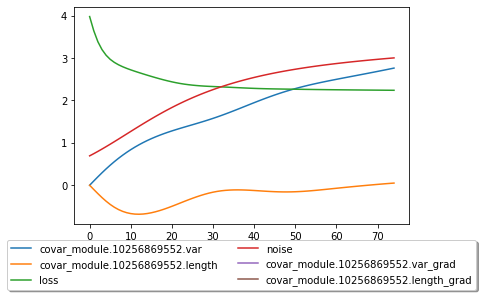

In [12]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [13]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([3.0107], grad_fn=<AddBackward0>)
tensor([1.0000e-04, 1.0000e-04], grad_fn=<AddBackward0>)


In [14]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [15]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([2.9601], requires_grad=True))
('covar_module.10256869552.var', Parameter containing:
tensor(2.7828, requires_grad=True))
('covar_module.10256869552.length', Parameter containing:
tensor(0.0582, requires_grad=True))


In [16]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[ 1.6164e+01,  1.4389e+01,  1.6116e+01,  ..., -1.9625e-01,
          1.3052e-02, -1.5387e-01],
        [ 1.4389e+01,  3.8429e+01,  1.4262e+01,  ...,  1.4867e+00,
         -1.5387e-01,  1.2454e+00],
        [ 1.6116e+01,  1.4262e+01,  1.6164e+01,  ..., -2.4855e-01,
          1.7403e-02, -1.9625e-01],
        ...,
        [-1.9625e-01,  1.4867e+00, -2.4855e-01,  ...,  3.8429e+01,
          1.4262e+01,  3.7861e+01],
        [ 1.3052e-02, -1.5387e-01,  1.7403e-02,  ...,  1.4262e+01,
          1.6164e+01,  1.4389e+01],
        [-1.5387e-01,  1.2454e+00, -1.9625e-01,  ...,  3.7861e+01,
          1.4389e+01,  3.8429e+01]])
torch.return_types.eig(
eigenvalues=tensor([[ 7.6549e+02,  0.0000e+00],
        [ 7.2094e+02,  0.0000e+00],
        [ 4.6458e+02,  0.0000e+00],
        [ 4.0270e+02,  0.0000e+00],
        [ 1.9957e+02,  0.0000e+00],
        [ 8.3302e+01,  0.0000e+00],
        [ 5.7253e+01,  0.0000e+00],
        [ 2.7386e+01,  0.0000e+00],
        [ 6.9742e+00,  0.0000e+00],
        

Text(0.5, 1.0, 'Observed Values (Likelihood)')

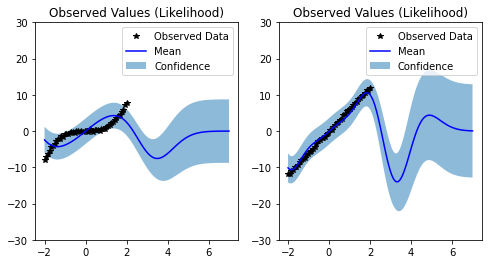

In [17]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [18]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

[ 7 10]

# Test Diffable SE Kernel

In [19]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [20]:
X = torch.linspace(float(-2), float(2), int(1))

In [35]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1).diff(x1).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[3.0]]

In [59]:
def coeffs(given_n):
    # See http://oeis.org/A096713
    real_n = int(given_n/2)
    m, k = var('m, k')
    # even
    # T(2*m, k) = (-1)^(m+k)*(2*m)!*2^(k-m)/((m-k)!*(2*k)!), k = 0..m.
    if given_n % 2 == 0:
        # This notation is only valid in iPython
        #T(m,k) = factorial(2*m)*2^(k-m)/(factorial(m-k)*factorial(2*k))
        # As an actual Python file I need to use:
        T = lambda m, k : factorial(2*m)*2**(k-m)/(factorial(m-k)*factorial(2*k))
    # odd
    # T(2*m+1, k) = (-1)^(m+k)*(2*m+1)!*2^(k-m)/((m-k)!*(2*k+1)!), k = 0..m. (End)
    else:
        # See above
        #T(m,k) = factorial(2*m+1)*2^(k-m)/(factorial(m-k)*factorial(2*k+1))
        T = lambda m, k: factorial(2*m+1)*2**(k-m)/(factorial(m-k)*factorial(2*k+1))

    return [int(T(real_n, k)) for k in range(real_n+1)]


In [60]:
for n in range(13): 
    print(f"{n}: {coeffs(n)}")

0: [1]
1: [1]
2: [1, 1]
3: [3, 1]
4: [3, 6, 1]
5: [15, 10, 1]
6: [15, 45, 15, 1]
7: [105, 105, 21, 1]
8: [105, 420, 210, 28, 1]
9: [945, 1260, 378, 36, 1]
10: [945, 4725, 3150, 630, 45, 1]
11: [10395, 17325, 6930, 990, 55, 1]
12: [10395, 62370, 51975, 13860, 1485, 66, 1]


In [51]:
from sage.functions.hypergeometric import closed_form
def A096713_row(n):

    R.<z> = ZZ[]

    h = hypergeometric([-n/2, (1-n)/2], [], -2*z)
    T = R(closed_form(h)).coefficients()
    return T[::-1]

for n in range(13): 
    print(A096713_row(n))


[1]
[1]
[-1, 1]
[-3, 1]
[3, -6, 1]
[15, -10, 1]
[-15, 45, -15, 1]
[-105, 105, -21, 1]
[105, -420, 210, -28, 1]
[945, -1260, 378, -36, 1]
[-945, 4725, -3150, 630, -45, 1]
[-10395, 17325, -6930, 990, -55, 1]
[10395, -62370, 51975, -13860, 1485, -66, 1]


In [55]:
kernel = Diff_SE_kernel(var=0, length=0)
kernel2 = Diff_SE_kernel(var=0, length=0)
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (1, 0, dx1, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
p = DiffMatrixKernel([[kernel, None], [None, None]])
cov_mod = p.diff(left_matrix=L, right_matrix=R)
print(cov_mod)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]
[0,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 0]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 0, 0]]]

[0,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 2]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 1, 0], [[tensor(1.), tensor(1.)], -1, 2, 2]]]

[1,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 1, 0]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 1, 1]]]

[1,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 1, 2]]
Resulting list (including parameters):[[[[tensor(1.), tensor(1.)], 1, 2, 1], [[tensor(1.), tensor(1.)], 0, 3, 3]]]




In [52]:
print(SE)
print(SE.diff(x1).diff(x2))
#print(SE.diff(x1).diff(x2))
#print(SE.diff(x1).diff(x2).diff(x1))
#print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
#float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)
(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)/l^2 - sigma^2*(x1 - x2)^2*e^(-1/2*(x1 - x2)^2/l^2)/l^4


In [23]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1^3 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

TypeError: Integer.degree() takes no arguments (1 given)

In [ ]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [ ]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

In [ ]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [ ]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


In [ ]:
print(X)
print(torch.Tensor(cov_matr).eig())

In [ ]:
exp(-(-2-0.66)^2/(2))

In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [ ]:
a, b, c, d, x, y, dx1 = var('a, b, c, d, x, y, dx1')
poly = (a*(2*(c+b)+a)+a)*y
#poly = a*b*dx1**3
print(type(poly))
#poly = 839840583*x^75
print(poly.degree(dx1))
print(poly.operands())
print([op.is_numeric() for op in poly.operands()])

In [ ]:
return_list = []
l1 = [[42, 17], [128, 256]]
for i, l in enumerate(l1):
    if i == 0:
        func1 = lambda : l[0]*l[1]
        return_list.append(func1)
    else: 
        func2 = lambda : l[0]*l[1]
        return_list.append(func2)

for func in return_list:
    print(func())